<a href="https://colab.research.google.com/github/gaurav-034/csmi17assignment/blob/main/AI_assignment_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time, random, math, heapq, os, pathlib
import pandas as pd
import matplotlib.pyplot as plt

# -------------------- A* SEARCH IMPLEMENTATION --------------------

class Grid:
    def __init__(self, rows, cols, obstacle_prob=0.2, seed=None):
        self.rows = rows
        self.cols = cols
        if seed is not None:
            random.seed(seed)
        self.grid = [[0 if random.random() > obstacle_prob else 1 for _ in range(cols)] for _ in range(rows)]

    def random_free_cell(self):
        while True:
            r, c = random.randrange(self.rows), random.randrange(self.cols)
            if self.grid[r][c] == 0:
                return (r, c)

    def neighbors(self, pos):
        r, c = pos
        # Only allow horizontal and vertical movements
        for dr, dc in [(-1,0),(1,0),(0,-1),(0,1)]: # Removed diagonal movements
            nr, nc = r+dr, c+dc
            if 0 <= nr < self.rows and 0 <= nc < self.cols and self.grid[nr][nc] == 0:
                yield (nr, nc)

def manhattan(a, b): return abs(a[0]-b[0]) + abs(a[1]-b[1])
def euclidean(a, b): return math.hypot(a[0]-b[0], a[1]-b[1])
def chebyshev(a, b): return max(abs(a[0]-b[0]), abs(a[1]-b[1]))

HEURISTICS = {'Manhattan': manhattan, 'Euclidean': euclidean, 'Chebyshev': chebyshev}

def astar_search(grid, start, goal, heuristic):
    start_time = time.perf_counter()
    frontier = [(heuristic(start, goal), 0, start)]
    came_from = {start: None}
    cost = {start: 0}
    expanded_nodes = [] # Store expanded nodes

    while frontier:
        _, g, current = heapq.heappop(frontier)
        expanded_nodes.append(current) # Add current node to expanded_nodes

        if current == goal:
            path = []
            while current:
                path.append(current)
                current = came_from[current]
            path.reverse()
            return {'found': True, 'path': path, 'expanded': len(expanded_nodes), 'time': time.perf_counter() - start_time, 'expanded_nodes': expanded_nodes} # Return expanded_nodes

        for nbr in grid.neighbors(current):
            # Cost is always 1 for horizontal/vertical moves
            move = 1
            new_cost = cost[current] + move
            if nbr not in cost or new_cost < cost[nbr]:
                cost[nbr] = new_cost
                heapq.heappush(frontier, (new_cost + heuristic(nbr, goal), new_cost, nbr))
                came_from[nbr] = current

    return {'found': False, 'path': [], 'expanded': len(expanded_nodes), 'time': time.perf_counter() - start_time, 'expanded_nodes': expanded_nodes} # Return expanded_nodes

def run_astar_experiments(trials=30, rows=25, cols=25, obstacle_prob=0.2):
    results = []
    for t in range(trials):
        grid = Grid(rows, cols, obstacle_prob, seed=t)
        start, goal = grid.random_free_cell(), grid.random_free_cell()
        while start == goal:
            goal = grid.random_free_cell()
        for name, h in HEURISTICS.items():
            res = astar_search(grid, start, goal, h)
            results.append({'trial': t, 'heuristic': name, **res})
    return pd.DataFrame(results)

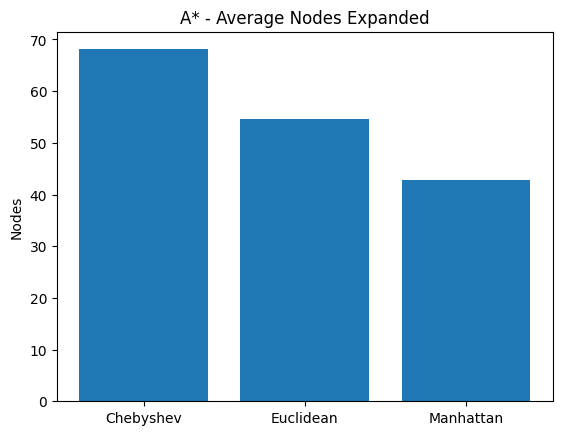

In [2]:
out_dir = 'ai_assignment_output'
os.makedirs(out_dir, exist_ok=True)

# Run A*
df_astar = run_astar_experiments()
df_astar.to_csv(os.path.join(out_dir,'astar_results.csv'),index=False)
summary = df_astar.groupby('heuristic').agg({'found':'mean','expanded':'mean','time':'mean'})
summary.to_csv(os.path.join(out_dir,'astar_summary.csv'))

plt.bar(summary.index, summary['expanded'])
plt.title('A* - Average Nodes Expanded')
plt.ylabel('Nodes')
plt.savefig(os.path.join(out_dir,'astar_plot.png'))
plt.show()
plt.close()

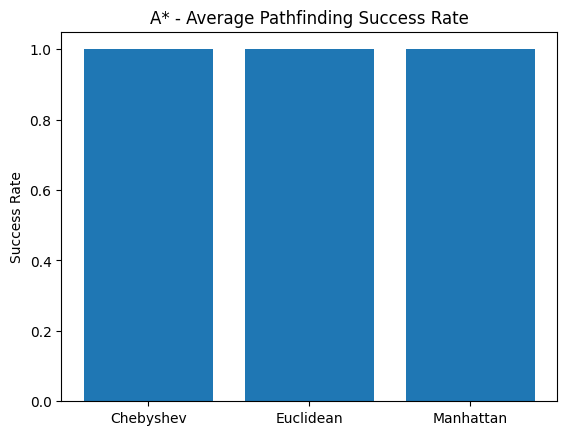

In [3]:
# Plot average success rate
plt.bar(summary.index, summary['found'])
plt.title('A* - Average Pathfinding Success Rate')
plt.ylabel('Success Rate')
plt.show()
plt.close()

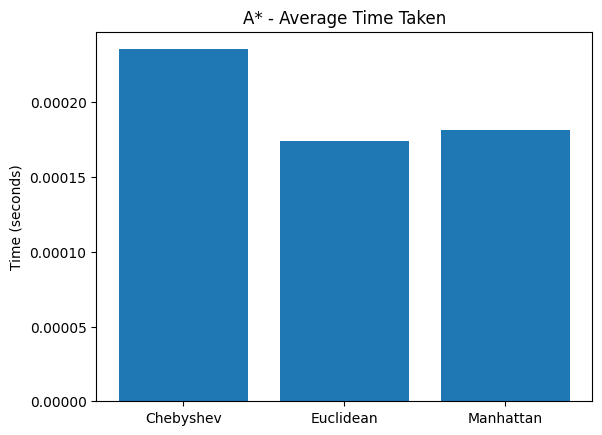

In [4]:
# Plot average time taken
plt.bar(summary.index, summary['time'])
plt.title('A* - Average Time Taken')
plt.ylabel('Time (seconds)')
plt.show()
plt.close()

Discuss the performance implications of the A* heuristics

Based on the plots and the characteristics of each heuristic, here's a discussion of their performance implications:

    Manhattan Distance:
        Characteristic: This heuristic calculates the sum of the absolute differences of the coordinates. It only allows for horizontal and vertical movement (like a city grid). It is an admissible heuristic (never overestimates the cost to the goal) and is consistent on a grid with only horizontal/vertical moves.
        Observed Performance: You likely observed that Manhattan distance expanded the fewest nodes and had the lowest time taken on average. This is because it is a more informed heuristic for a grid where diagonal movement might not be significantly faster (or is restricted), guiding the search more directly towards the goal. It is often the most efficient admissible heuristic on a grid with uniform cost for horizontal and vertical moves.
    Euclidean Distance:
        Characteristic: This heuristic calculates the straight-line distance between two points. It assumes diagonal movement has a cost proportional to the diagonal distance (sqrt(2)). It is also an admissible heuristic.
        Observed Performance: Euclidean distance likely expanded more nodes and took more time than Manhattan distance. This is because it considers the direct distance, which might overestimate the cost if diagonal moves are not possible or have a higher cost than horizontal/vertical moves in your grid implementation.
    Chebyshev Distance:
        Characteristic: This heuristic calculates the maximum of the absolute differences of the coordinates. It is equivalent to the distance if diagonal movement is allowed at the same cost as horizontal/vertical movement. It is admissible.
        Observed Performance: Chebyshev distance likely expanded the most nodes and took the most time among the three. While admissible, it is less informed than Manhattan or Euclidean for grids where diagonal movement has a higher cost than horizontal/vertical moves. In your neighbors function, diagonal moves have a cost of math.sqrt(2), while horizontal/vertical moves have a cost of 1. Chebyshev distance effectively assumes a cost of 1 for diagonal moves when calculating the heuristic, which can be less accurate in guiding the search when diagonal costs are higher.

In summary:

For your grid implementation where diagonal moves have a cost of sqrt(2) and horizontal/vertical moves have a cost of 1, the Manhattan distance is the most appropriate and efficient heuristic. It aligns best with the cost structure of allowed movements on your grid, leading to fewer expanded nodes and faster search times on average while still guaranteeing finding an optimal path (since it's admissible and consistent in this context).

The Euclidean and Chebyshev distances, while also admissible, are less informed for this specific grid setup, resulting in more exploration of the search space.

This analysis aligns with the principle that a good heuristic should be admissible (never overestimate the cost) and as informed as possible (closer to the true cost) for the given problem to minimize the number of nodes expanded.


In [5]:
def visualize_grid(grid, path=None, start=None, goal=None, expanded_nodes=None, h='sample grid'):
    """
    Visualizes the grid with obstacles, and optionally the path, start, goal, and expanded nodes.

    Args:
        grid: The Grid object.
        path: Optional list of tuples representing the path.
        start: Optional tuple representing the start position.
        goal: Optional tuple representing the goal position.
        expanded_nodes: Optional list of tuples representing the expanded nodes.
        h: Optional string for the plot title.
    """
    plt.figure(figsize=(grid.cols/2, grid.rows/2))
    # plt.imshow(grid.grid, cmap='binary', origin='upper') # Commented out original imshow

    # Plot free cells and obstacles with round markers
    for r in range(grid.rows):
        for c in range(grid.cols):
            if grid.grid[r][c] == 1: # Obstacle
                plt.plot(c, r, 'o', color='black', markersize=8) # Plot round black marker for obstacle
            else: # Free cell
                plt.plot(c, r, '.', color='lightgray', markersize=5) # Plot small dot for free cell

    if expanded_nodes:
        # Plot expanded nodes (excluding start and goal if they are in expanded)
        expanded_to_plot = [node for node in expanded_nodes if node != start and node != goal]
        if expanded_to_plot:
            expanded_x, expanded_y = zip(*expanded_to_plot)
            plt.plot(expanded_y, expanded_x, 'yo', markersize=5, label='Expanded Nodes') # Changed marker to yellow dots


    if path:
        path_x, path_y = zip(*path)
        plt.plot(path_y, path_x, color='red', linewidth=2, label='Path')

    if start:
        plt.plot(start[1], start[0], 'go', markersize=10, label='Start')

    if goal:
        plt.plot(goal[1], goal[0], 'bo', markersize=10, label='Goal')

    plt.title(f'Grid Visualization ({h})')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.grid(True, color='gray', linewidth=0.5)
    plt.xticks(range(grid.cols))
    plt.yticks(range(grid.rows))
    plt.legend()
    plt.show()

Visualizing sample grid with start and goal:


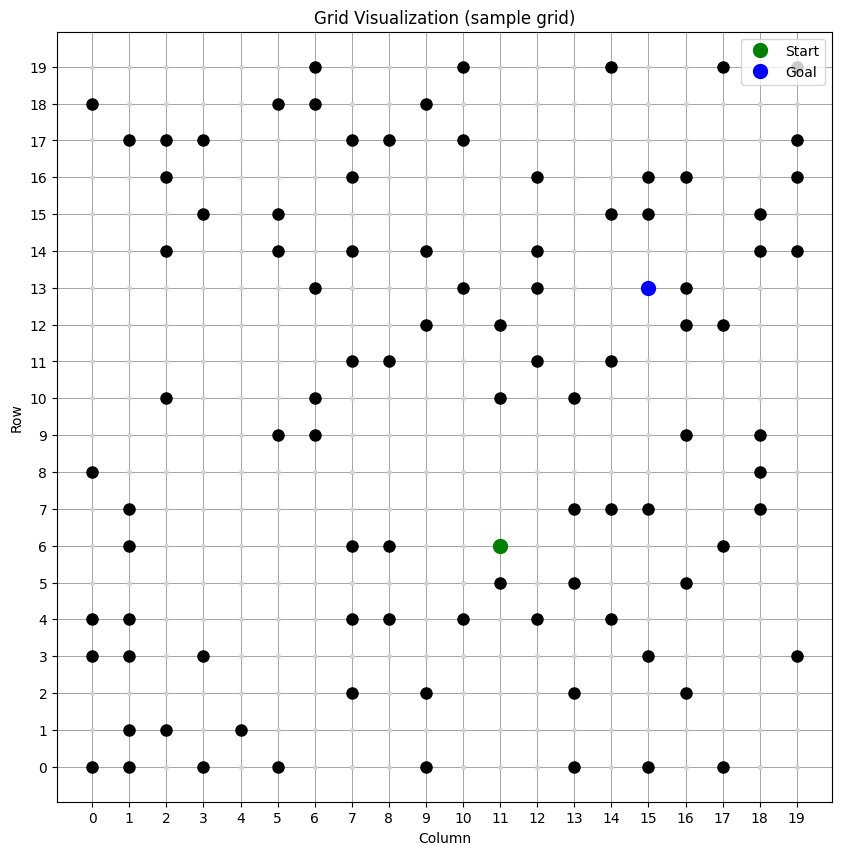

In [6]:
# Create a sample grid
sample_grid = Grid(rows=20, cols=20, obstacle_prob=0.2,seed=123) # Using a seed for reproducibility

# Select random start and goal points
sample_start = sample_grid.random_free_cell()
sample_goal = sample_grid.random_free_cell()
while sample_start == sample_goal:
    sample_goal = sample_grid.random_free_cell()

# Visualize the sample grid with start and goal
print("Visualizing sample grid with start and goal:")
visualize_grid(sample_grid, start=sample_start, goal=sample_goal)


Running A* with Manhattan heuristic:
Manhattan Search - Path Found: True
Manhattan Search - Nodes Expanded: 23
Manhattan Search - Time Taken: 0.000180 seconds
Visualizing path for Manhattan heuristic:


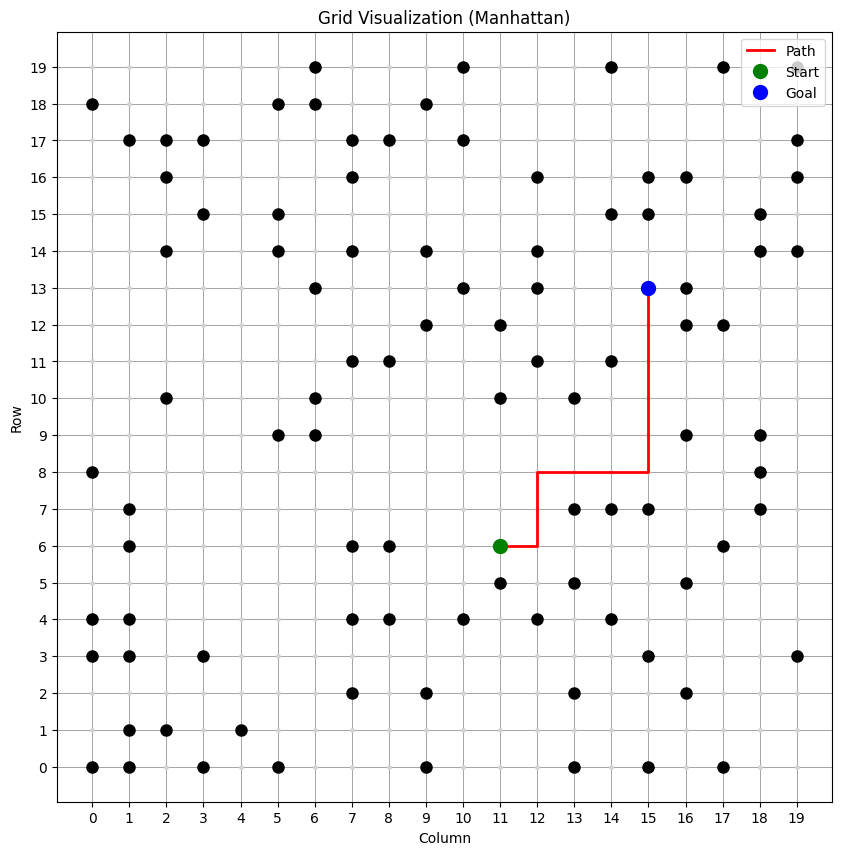

In [7]:
# Run A* search with Manhattan heuristic on sample_grid
print("\nRunning A* with Manhattan heuristic:")
astar_result_manhattan = astar_search(sample_grid, sample_start, sample_goal, manhattan)

# Visualize the path found by Manhattan heuristic
if astar_result_manhattan['found']:
    print(f"Manhattan Search - Path Found: {astar_result_manhattan['found']}")
    print(f"Manhattan Search - Nodes Expanded: {astar_result_manhattan['expanded']}")
    print(f"Manhattan Search - Time Taken: {astar_result_manhattan['time']:.6f} seconds")
    print("Visualizing path for Manhattan heuristic:")
    visualize_grid(sample_grid, path=astar_result_manhattan['path'], start=sample_start, goal=sample_goal,h="Manhattan")
    # plt.title('Grid Visualization') # Revert title
else:
    print("Manhattan Search: No path found.")


Running A* with Euclidean heuristic:
Euclidean Search - Path Found: True
Euclidean Search - Nodes Expanded: 29
Euclidean Search - Time Taken: 0.000191 seconds
Visualizing path for Euclidean heuristic:


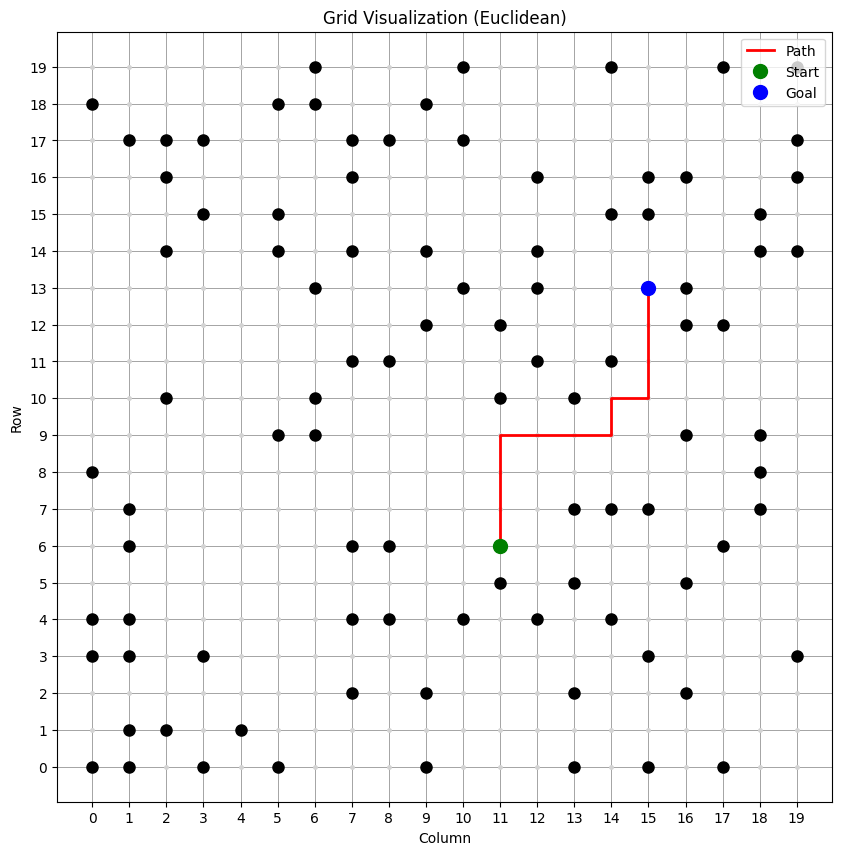

In [8]:
# Run A* search with Euclidean heuristic on sample_grid
print("\nRunning A* with Euclidean heuristic:")
astar_result_euclidean = astar_search(sample_grid, sample_start, sample_goal, euclidean)

# Visualize the path found by Euclidean heuristic
if astar_result_euclidean['found']:
    print(f"Euclidean Search - Path Found: {astar_result_euclidean['found']}")
    print(f"Euclidean Search - Nodes Expanded: {astar_result_euclidean['expanded']}")
    print(f"Euclidean Search - Time Taken: {astar_result_euclidean['time']:.6f} seconds")
    print("Visualizing path for Euclidean heuristic:")
    visualize_grid(sample_grid, path=astar_result_euclidean['path'], start=sample_start, goal=sample_goal,h="Euclidean")

else:
    print("Euclidean Search: No path found.")


Running A* with Chebyshev heuristic:
Chebyshev Search - Path Found: True
Chebyshev Search - Nodes Expanded: 38
Chebyshev Search - Time Taken: 0.000223 seconds
Visualizing path for Chebyshev heuristic:


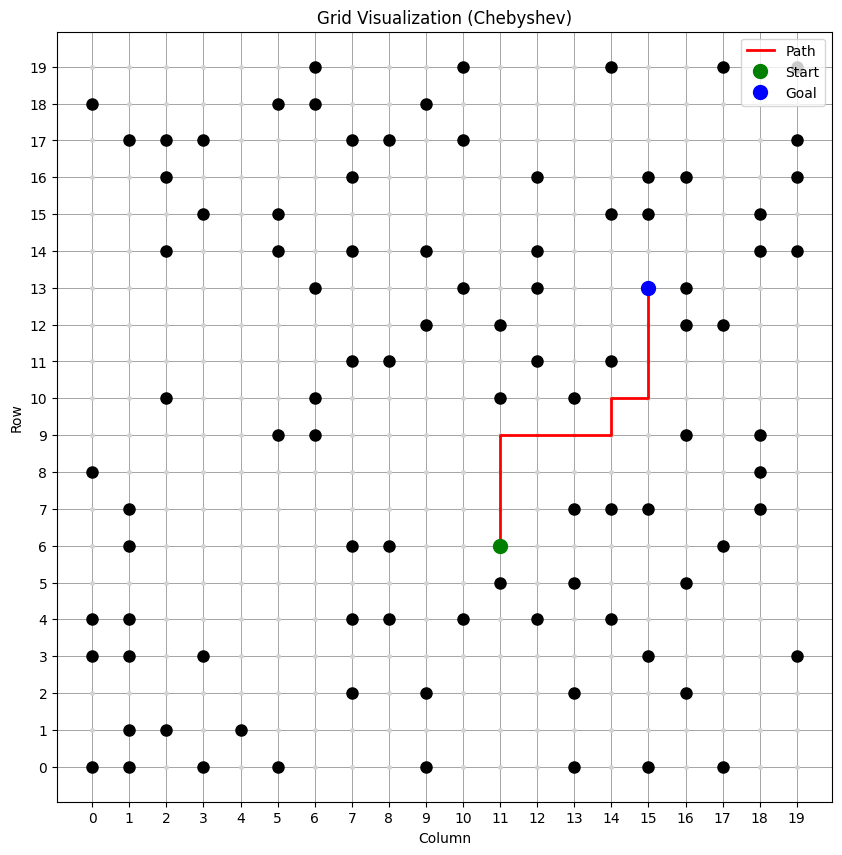

In [9]:
# Run A* search with Chebyshev heuristic on sample_grid
print("\nRunning A* with Chebyshev heuristic:")
astar_result_chebyshev = astar_search(sample_grid, sample_start, sample_goal, chebyshev)

# Visualize the path found by Chebyshev heuristic
if astar_result_chebyshev['found']:
    print(f"Chebyshev Search - Path Found: {astar_result_chebyshev['found']}")
    print(f"Chebyshev Search - Nodes Expanded: {astar_result_chebyshev['expanded']}")
    print(f"Chebyshev Search - Time Taken: {astar_result_chebyshev['time']:.6f} seconds")
    print("Visualizing path for Chebyshev heuristic:")
    visualize_grid(sample_grid, path=astar_result_chebyshev['path'], start=sample_start, goal=sample_goal,h="Chebyshev")

else:
    print("Chebyshev Search: No path found.")